In [22]:
import pandas as pd 
from pandas import DataFrame as df 
import numpy as np 
import scipy.stats as st 
import datetime as dt 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LinearRegression
%matplotlib inline 

In [2]:
data2000 = pd.read_csv('US2000.csv').dropna()

In [3]:
data2000['date'] = pd.to_datetime(data2000['date'], format='%d/%m/%Y')
data2000['PRC'][data2000['PRC'] < 0] *= -1
data2000['AdjP'] = data2000['PRC'] / data2000['CFACPR']
data2000['Ret'] = np.log(data2000['AdjP'] / data2000['AdjP'].shift())
data2000 = data2000.groupby('PERMNO').apply(lambda x: x.iloc[1:]).reset_index(drop=True).dropna()
data2000['year'] = data2000['date'].dt.year

/Users/Chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Chris/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
data2000.head()

,PERMNO,date,PERMCO,PRC,VOL,CFACPR,sprtrn,AdjP,Ret,year
0,10001,2000-01-04,7953,8.4375,1080.0,1.5,-0.038345,5.625000,-0.014706,2000
1,10001,2000-01-05,7953,8.5625,1711.0,1.5,0.001922,5.708333,0.014706,2000
2,10001,2000-01-06,7953,8.5000,580.0,1.5,0.000956,5.666667,-0.007326,2000
3,10001,2000-01-07,7953,8.4375,1406.0,1.5,0.027090,5.625000,-0.007380,2000
4,10001,2000-01-10,7953,8.4375,3390.0,1.5,0.011190,5.625000,0.000000,2000


In [18]:
try: 
    smry = pd.read_csv('smry.csv')
except: 
    smry = data2000.groupby(['PERMNO', 'year'], as_index=False).agg({'date': 'max', 'Ret': ['size', 'mean', 'var', st.skew, st.kurtosis, valueAR, cVaR, maxDDRet, semiv]}).dropna()
    smry.columns = ['PERMNO', 'year', 'max', 'size', 'mean', 'variance', 'skew', 'kurtosis', 'VaR', 'CVaR', 'MaxDD', 'Semiv']
    smry['kurtosis'] += 3
    smry = smry[smry['size'] > 200]
    smry = smry.groupby('year', as_index=False).apply(lambda x: x[x['max'] == max(x['max'])]).reset_index(drop=True)
    smry['skewdec'] = pd.qcut(smry['skew'], 10, labels=False)
    smry['kurtdec'] = pd.qcut(smry['kurtosis'], 10, labels=False)
    smry = smry.sort_values(['PERMNO', 'year'])
    smry[['lagkd', 'lagsd']] = smry[['skewdec', 'kurtdec']].shift()
    smry = smry.groupby('PERMNO').apply(lambda x: x.iloc[1:]).reset_index(drop=True).dropna()
    smry['year'] = pd.to_datetime(smry['year'], format='%Y')
    smry = smry.dropna()
    smry

In [8]:
# Want to hold higher decile skew and lower decile kurtosis 
skewPort = smry[(smry['lagsd'] == 0) | (smry['lagsd'] == 9)]
skewPort['mean'][skewPort['lagsd'] == 0] *= -1
kurtPort = smry[(smry['lagkd'] == 0) | (smry['lagkd'] == 9)]
kurtPort['mean'][kurtPort['lagkd'] == 9] *= -1
skewkurtPort = smry[((smry['lagsd'] == 0) & (smry['lagkd'] == 9) | (smry['lagsd'] == 9) & (smry['lagkd'] == 0))]
skewkurtPort['mean'][skewkurtPort['lagkd'] == 9] *= -1
skewkurtPort

KeyError: 'lagsd'

In [9]:
skewPort = skewPort.groupby('year', as_index=False).agg({'mean': ['size', 'sum', 'mean'], 'lagsd': 'sum'})
skewPort.columns = ['year', 'stocks', 'return', 'avRet', 'decSum']
skewPort['decSum'] /= 9
skewPort

NameError: name 'skewPort' is not defined

In [10]:
plt.plot(skewPort['year'], 2*skewPort['avRet'])

kurtPort = kurtPort.groupby('year', as_index=False).agg({'mean': ['size', 'sum', 'mean'], 'lagsd': 'sum'})
kurtPort.columns = ['year', 'stocks', 'return', 'avRet', 'decSum']
kurtPort['decSum'] /= 9
kurtPort

NameError: name 'skewPort' is not defined

In [11]:
plt.plot(kurtPort['year'], 2*kurtPort['avRet'])

NameError: name 'kurtPort' is not defined

In [12]:
skewkurtPort = skewkurtPort.groupby('year', as_index=False).agg({'mean': ['size', 'sum', 'mean'], 'lagsd': 'sum'})
skewkurtPort.columns = ['year', 'stocks', 'return', 'avRet', 'decSum']
skewkurtPort['decSum'] /= 9
skewkurtPort

NameError: name 'skewkurtPort' is not defined

In [13]:
plt.plot(skewkurtPort['year'], 2*skewkurtPort['avRet'])

NameError: name 'skewkurtPort' is not defined

In [14]:
plt.plot(skewkurtPort['year'], skewkurtPort['avRet'])

NameError: name 'skewkurtPort' is not defined

In [15]:
from sklearn.linear_model import LinearRegression
skewkurtModel = LinearRegression().fit(smry['skew'].values.reshape(-1, 1), smry['kurtosis'].values)
print(skewkurtModel.intercept_)
print(skewkurtModel.coef_)
print(skewkurtModel.score(smry['skew'].values.reshape(-1, 1), smry['kurtosis'].values))

8.888805728628343
[-3.42253654]
0.11745976522335733


In [16]:
pred = skewkurtModel.predict(smry['skew'].values.reshape(-1, 1))

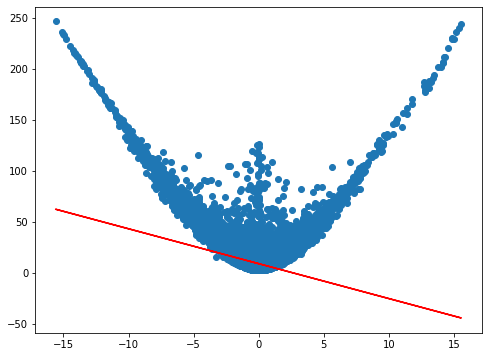

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(smry['skew'].values.reshape(-1, 1), smry['kurtosis'].values)
plt.plot(smry['skew'].values.reshape(-1, 1), pred, color='r')

In [18]:
newsmry = smry
newsmry['sqskew'] = newsmry['skew'] ** 2 

In [19]:
newsmry.head()

,PERMNO,year,mean,variance,skew,kurtosis,VaR,CVaR,MaxDD,Semiv,...,nkurtosis,mean2,variance2,skew2,kurtosis2,mean3,variance3,skew3,kurtosis3,sqskew
0,10001,2000-01-01,0.000517,0.000516,-0.013382,3.730050,0.038458,0.049853,0.152208,0.015620,...,11.800299,2.677344e-07,2.658095e-07,0.000179,13.913269,1.385340e-10,1.370426e-10,-0.000002,51.897183,0.000179
1,10001,2001-01-01,0.000648,0.000908,-0.358962,11.800299,0.042742,0.067054,0.305908,0.022719,...,4.406784,4.200004e-07,8.246121e-07,0.128854,139.247057,2.721915e-10,7.488150e-10,-0.046254,1643.156918,0.128854
2,10001,2002-01-01,-0.001759,0.000335,-0.258249,4.406784,0.033637,0.043516,0.384337,0.013564,...,9.426603,3.092481e-06,1.121894e-07,0.066693,19.419741,-5.438267e-09,3.757747e-11,-0.017223,85.578596,0.066693
3,10001,2003-01-01,-0.000839,0.001030,-0.040212,9.426603,0.044208,0.080958,0.452394,0.025295,...,7.658105,7.040351e-07,1.060161e-06,0.001617,88.860835,-5.907334e-10,1.091586e-09,-0.000065,837.655778,0.001617
4,10001,2004-01-01,0.000588,0.000714,0.638468,7.658105,0.041834,0.058435,0.335233,0.018147,...,7.646879,3.455303e-07,5.100324e-07,0.407642,58.646577,2.031090e-10,3.642475e-10,0.260266,449.121667,0.407642


In [20]:
skewkurtModel.fit(newsmry[['skew', 'sqskew']], newsmry['kurtosis'])
pred = skewkurtModel.predict(newsmry[['skew', 'sqskew']])

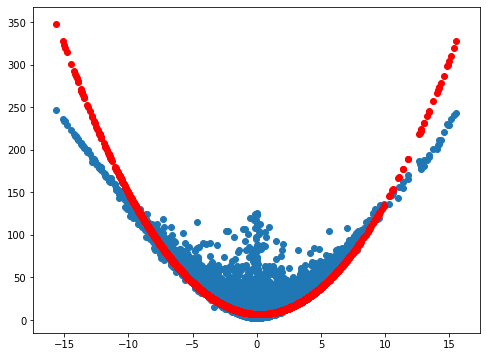

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(smry['skew'].values.reshape(-1, 1), smry['kurtosis'].values)
plt.scatter(newsmry['skew'].values.reshape(-1, 1), pred, color='r')

In [22]:
print(skewkurtModel.intercept_)
print(skewkurtModel.coef_)
print(skewkurtModel.score(newsmry[['skew', 'sqskew']], newsmry['kurtosis']))

6.968206325556592
[-0.5912198   1.36240201]
0.8094022696834318


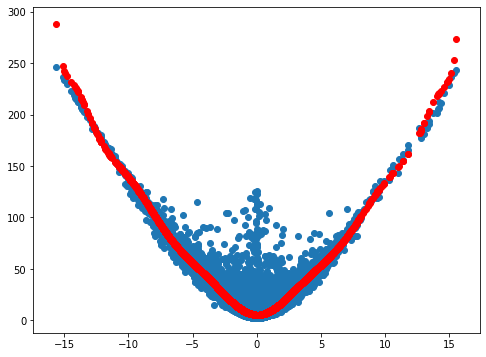

In [23]:
newsmry['s4'] = newsmry['skew'] ** 4; newsmry['s6'] = newsmry['skew'] ** 6
newsmry['s8'] = newsmry['skew'] ** 8; newsmry['s10'] = newsmry['skew'] ** 10
newsmry['s12'] = newsmry['skew'] ** 12; newsmry['s14'] = newsmry['skew'] ** 14
skewkurtModel.fit(newsmry[['skew', 'sqskew', 's4', 's6', 's8', 's10', 's12', 's14']], newsmry['kurtosis'])
pred = skewkurtModel.predict(newsmry[['skew', 'sqskew', 's4', 's6', 's8', 's10', 's12', 's14']])
plt.figure(figsize=(8,6))
plt.scatter(smry['skew'].values.reshape(-1, 1), smry['kurtosis'].values)
plt.scatter(newsmry['skew'].values.reshape(-1, 1), pred, color='r')

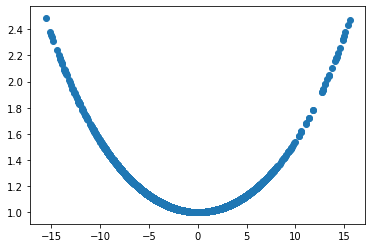

In [24]:
plt.scatter(smry['skew'], np.cosh(0.1 * smry['skew']))

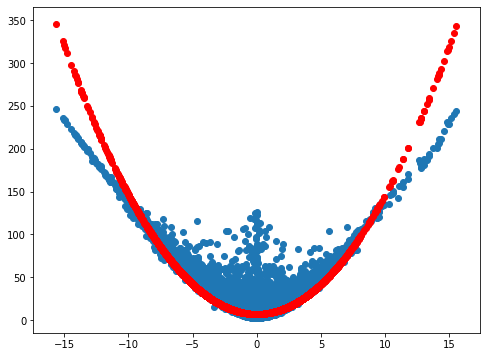

In [25]:
skewkurtModel.fit(np.cosh(0.0000001 * smry['skew']).values.reshape(-1,1), smry['kurtosis'])
pred = skewkurtModel.predict(np.cosh(0.0000001 * smry['skew']).values.reshape(-1,1))
plt.figure(figsize=(8,6))
plt.scatter(smry['skew'], smry['kurtosis'])
plt.scatter(smry['skew'], pred, color='r')

In [26]:
print('R2:', skewkurtModel.score(np.cosh(0.001 * smry['skew']).values.reshape(-1,1), smry['kurtosis']))

R2: -8373433797591973.0


In [27]:
smry['skew'].shift(-1)

0       -0.358962
1       -0.258249
2       -0.040212
3        0.638468
4        1.392394
           ...   
90539    0.566829
90540    0.486219
90541    0.061185
90542   -0.655718
90543         NaN
Name: skew, Length: 90544, dtype: float64

In [6]:
data2000.head()

,PERMNO,date,PERMCO,PRC,VOL,CFACPR,sprtrn,AdjP,Ret,year
0,10001,2000-01-04,7953,8.4375,1080.0,1.5,-0.038345,5.625000,-0.014706,2000
1,10001,2000-01-05,7953,8.5625,1711.0,1.5,0.001922,5.708333,0.014706,2000
2,10001,2000-01-06,7953,8.5000,580.0,1.5,0.000956,5.666667,-0.007326,2000
3,10001,2000-01-07,7953,8.4375,1406.0,1.5,0.027090,5.625000,-0.007380,2000
4,10001,2000-01-10,7953,8.4375,3390.0,1.5,0.011190,5.625000,0.000000,2000


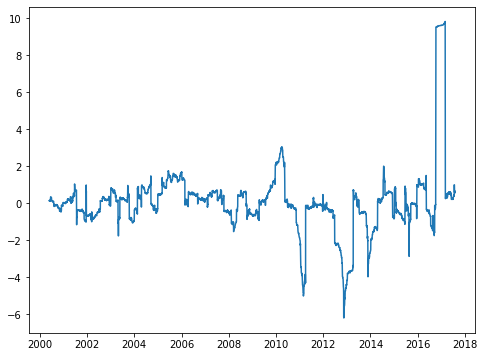

In [7]:
plt.figure(figsize=(8,6))
plt.plot(data2000['date'][data2000['PERMNO']==data2000['PERMNO'][0]], pd.DataFrame(data2000['Ret'][data2000['PERMNO']==data2000['PERMNO'][0]]).rolling(100).skew())

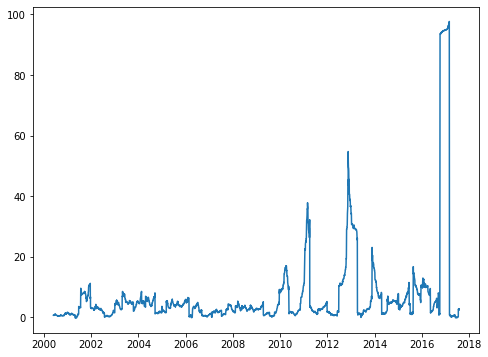

In [8]:
plt.figure(figsize=(8,6))
plt.plot(data2000['date'][data2000['PERMNO']==data2000['PERMNO'][0]], pd.DataFrame(data2000['Ret'][data2000['PERMNO']==data2000['PERMNO'][0]]).rolling(100).kurt())

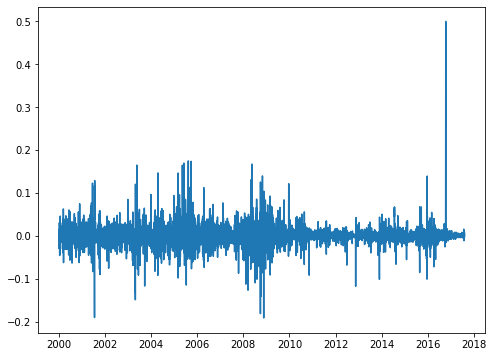

In [9]:
plt.figure(figsize=(8,6))
plt.plot(data2000['date'][data2000['PERMNO']==data2000['PERMNO'][0]], data2000['Ret'][data2000['PERMNO']==data2000['PERMNO'][0]])

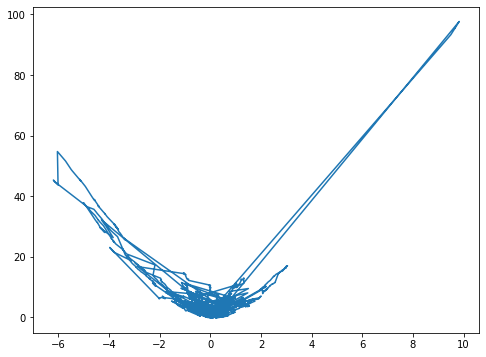

In [10]:
plt.figure(figsize=(8,6))
plt.plot(pd.DataFrame(data2000['Ret'][data2000['PERMNO']==data2000['PERMNO'][0]]).rolling(100).skew(), pd.DataFrame(data2000['Ret'][data2000['PERMNO']==data2000['PERMNO'][0]]).rolling(100).kurt())

In [11]:
data2000['Ret'][data2000['PERMNO']==data2000['PERMNO'][0]] > 0.3

0       False
1       False
2       False
3       False
4       False
        ...  
4419    False
4420    False
4421    False
4422    False
4423    False
Name: Ret, Length: 4424, dtype: bool

In [12]:
firstCo = data2000[data2000['PERMNO']==data2000['PERMNO'][0]]
firstCo

,PERMNO,date,PERMCO,PRC,VOL,CFACPR,sprtrn,AdjP,Ret,year
0,10001,2000-01-04,7953,8.4375,1080.0,1.5,-0.038345,5.625000,-0.014706,2000
1,10001,2000-01-05,7953,8.5625,1711.0,1.5,0.001922,5.708333,0.014706,2000
2,10001,2000-01-06,7953,8.5000,580.0,1.5,0.000956,5.666667,-0.007326,2000
3,10001,2000-01-07,7953,8.4375,1406.0,1.5,0.027090,5.625000,-0.007380,2000
4,10001,2000-01-10,7953,8.4375,3390.0,1.5,0.011190,5.625000,0.000000,2000
...,...,...,...,...,...,...,...,...,...,...
4419,10001,2017-07-28,7953,13.0000,9166.0,1.0,-0.001341,13.000000,0.000000,2017
4420,10001,2017-07-31,7953,12.9500,30166.0,1.0,-0.000728,12.950000,-0.003854,2017
4421,10001,2017-08-01,7953,13.0500,153297.0,1.0,0.002449,13.050000,0.007692,2017
4422,10001,2017-08-02,7953,13.1000,509562.0,1.0,0.000493,13.100000,0.003824,2017


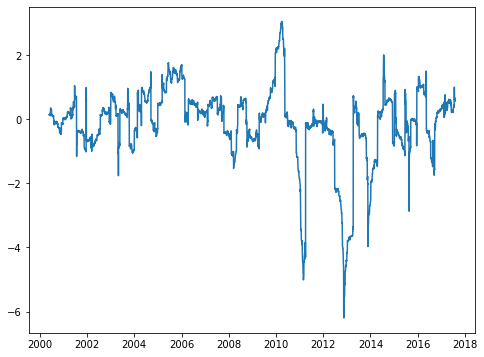

In [13]:
plt.figure(figsize=(8,6))
plt.plot(firstCo['date'][firstCo['Ret'] < 0.4], firstCo['Ret'][firstCo['Ret'] < 0.4].rolling(100).skew())

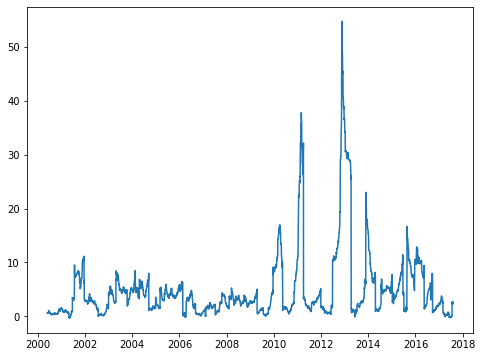

In [14]:
plt.figure(figsize=(8,6))
plt.plot(firstCo['date'][firstCo['Ret'] < 0.4], firstCo['Ret'][firstCo['Ret'] < 0.4].rolling(100).kurt())

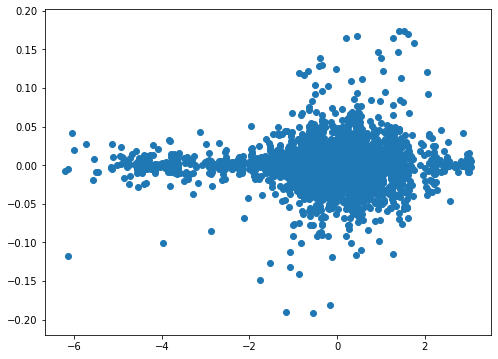

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(firstCo['Ret'][firstCo['Ret'] < 0.4].rolling(100).skew(), firstCo['Ret'][firstCo['Ret'] < 0.4])

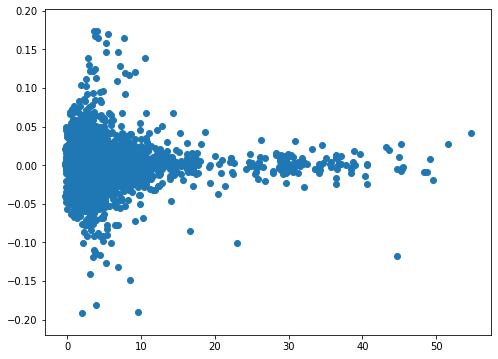

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(firstCo['Ret'][firstCo['Ret'] < 0.4].rolling(100).kurt(), firstCo['Ret'][firstCo['Ret'] < 0.4])

In [19]:
p = 100/2**6
wideSK = smry[['skew', 'kurtosis']][:]
wideSK = wideSK[(wideSK['skew'] < np.percentile(wideSK['skew'], p)) | (wideSK['skew'] > np.percentile(wideSK['skew'], 100-p))]
wideSK

,skew,kurtosis
52,2.832838,26.186570
60,7.272868,89.794788
65,2.872182,46.321674
85,-4.314642,49.333383
96,-5.741727,66.965722
...,...,...
90408,4.339294,43.903257
90423,-4.137688,48.110636
90431,5.901264,65.093808
90521,-5.357357,51.497479


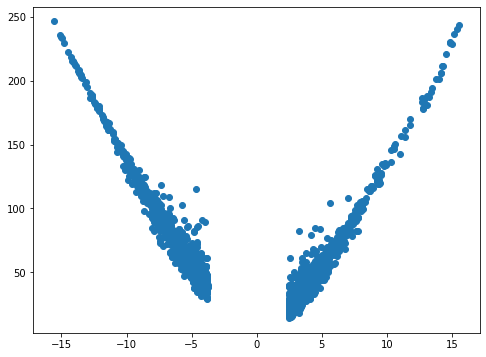

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(wideSK['skew'], wideSK['kurtosis'])

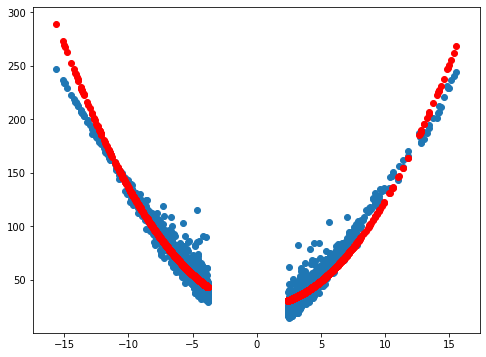

In [23]:
wideSK['sqskew'] = wideSK['skew']**2
model = LinearRegression()
model.fit(wideSK[['skew', 'sqskew']], wideSK['kurtosis'])
pred = model.predict(wideSK[['skew', 'sqskew']])
plt.figure(figsize=(8,6))
plt.scatter(wideSK['skew'].values.reshape(-1, 1), wideSK['kurtosis'].values)
plt.scatter(wideSK['skew'].values.reshape(-1, 1), pred, color='r')

In [24]:
print(model.intercept_, model.coef_)

25.55344180922797 [-0.60157754  1.04225107]


In [25]:
model.score(wideSK[['skew', 'sqskew']], wideSK['kurtosis'])

0.9467901904030456

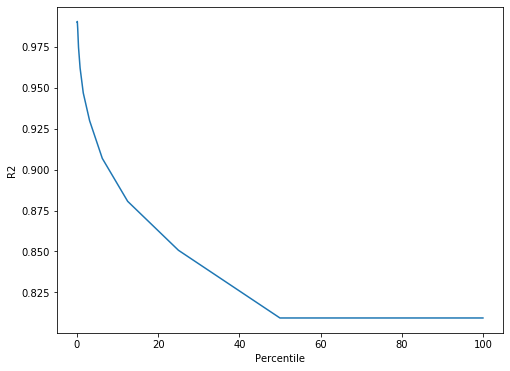

In [26]:
n = 12
rsq = np.zeros(n)
dec = np.zeros(n)
for i in range(n):
    p = 100/2**i
    dec[i] = p
    wideSK = smry[['skew', 'kurtosis']][:]
    wideSK = wideSK[(wideSK['skew'] < np.percentile(wideSK['skew'], p)) | (wideSK['skew'] > np.percentile(wideSK['skew'], 100-p))]
    wideSK['sqskew'] = wideSK['skew']**2
    model = LinearRegression()
    model.fit(wideSK[['skew', 'sqskew']], wideSK['kurtosis'])
    pred = model.predict(wideSK[['skew', 'sqskew']])
    rsq[i] = model.score(wideSK[['skew', 'sqskew']], wideSK['kurtosis'])

plt.figure(figsize=(8, 6))
plt.plot(dec, rsq)
plt.xlabel('Percentile')
plt.ylabel('R2')
plt.show()

In [33]:
model = LinearRegression()
model.fit(smry[['variance', 'skew', 'kurtosis']], smry['mean'])
pred = model.predict(smry[['variance', 'skew', 'kurtosis']])

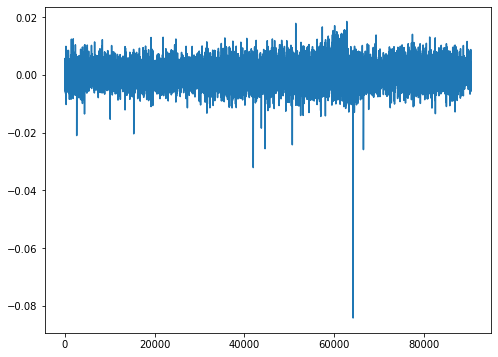

In [41]:
plt.figure(figsize=(8,6))
plt.plot(pred - smry['mean'])

-8.967173643795155e-20 4.013218533699252e-06 -0.5150980425006372 44.90766125631032


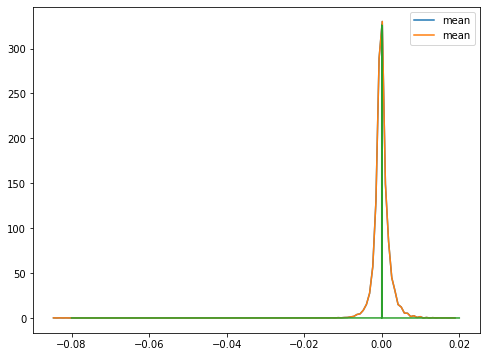

In [77]:
res = pred - smry['mean']
print(np.mean(res), np.var(res), st.skew(res), st.kurtosis(res, fisher=False))
plt.figure(figsize=(8,6))
sns.kdeplot(res)
plt.plot(np.linspace(-.08, .02, len(res)), np.max(sns.kdeplot(res).get_lines()[0].get_data())*10**-5*st.norm.pdf(np.linspace(-.08, .02, len(res)), np.mean(res), np.var(res)))

330.19465553909845

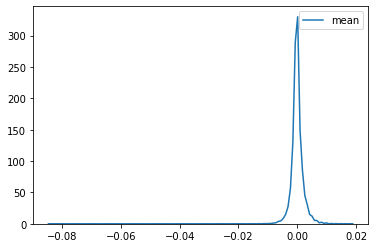

In [76]:
np.max(sns.kdeplot(res).get_lines()[0].get_data())

In [80]:
st.normaltest(res)

NormaltestResult(statistic=32029.007885529096, pvalue=0.0)

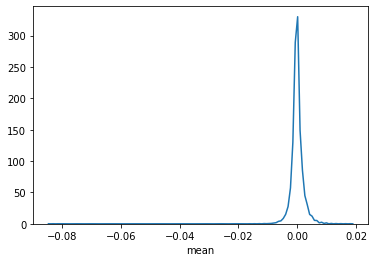

In [82]:
sns.distplot(res, hist=False)